<a href="https://colab.research.google.com/github/suresh-venkate/Code_Repositories/blob/main/Deep_Learning/Computer_Vision/Image_Classification/Stanford_Cars_Dataset/Stanford_Cars_Dataset_Classification_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stanford Car Dataset Classification - TF2-Keras version

**Author:** Suresh Venkatesan

* Problem statement: Classify images of cars into their respective classes.
* Dataset to be used: Stanford Car Dataset ([Main Link](https://ai.stanford.edu/~jkrause/cars/car_dataset.html)    [Kaggle Link](https://www.kaggle.com/jutrera/stanford-car-dataset-by-classes-folder))

# Complete preliminaries

## Connect to Google Drive

In [1]:
### Use this for Google Colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install Keras Tuner

In [2]:
%%capture

!pip install -q -U keras-tuner

## Import required libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import os
import shutil
import pytz
import math
import cv2
import pprint
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, models, Model
from tensorflow.keras import optimizers, losses, metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers.schedules import InverseTimeDecay 
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import apply_affine_transform
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications import mobilenet
from tensorflow.keras.applications import inception_v3

import kerastuner as kt
from kerastuner import HyperModel

from tqdm import tqdm
from sklearn.model_selection import train_test_split

import imgaug as ia
from imgaug import augmenters as iaa

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

%load_ext tensorboard

## Define directory paths

In [4]:
# Define base path for TensorBoard Logs directory
tb_logs_base_path = "/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/Stanford_Car_Dataset/TB_Logs/"
os.makedirs(tb_logs_base_path, exist_ok = True) # Don't raise any exception if directory exists
# Define base path for Keras Tuner Logs directory
kt_logs_base_path = "/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/Stanford_Car_Dataset/KT_Logs/"
os.makedirs(kt_logs_base_path, exist_ok = True) # Don't raise any exception if directory exists
# Define base path for storing all outputs related to model / training
out_base_path = "/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/Stanford_Car_Dataset/Training_Outputs/"
os.makedirs(out_base_path, exist_ok = True) # Don't raise any exception if directory exists
# Define base path of dataset
dataset_path = "/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Datasets/Image_Datasets/Stanford_Car_Dataset/"

# Dataset - Import, EDA and pre-process

## Import dataset

In [5]:
# Copy dataset from Google Drive
img_zip_file_name = "Consolidated_Dataset.zip"
img_zip_file_path = os.path.join(dataset_path, img_zip_file_name)

# Get start time of run and display it
start_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
print("Started dataset copy at %s..." %(start_time.strftime("%H:%M:%S")), end = ' ')
!cp {img_zip_file_path} .

# Unzip dataset file
print("Unzipping dataset...")
!unzip -q Consolidated_Dataset.zip
# Delete zip file
!rm Consolidated_Dataset.zip

# Get end time of run and display elapsed time
end_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
elap_time = ((end_time - start_time).total_seconds())/60
print("Completed at %s. Elapsed time = %0.2f minutes." %(end_time.strftime("%H:%M:%S"), elap_time))

Started dataset copy at 19:46:53... Unzipping dataset...
Completed at 19:47:41. Elapsed time = 0.79 minutes.


## Load annotation files to Pandas Dataframes

In [6]:
# Load train annotation file in a DataFrame
ann_train_csv_path = './annot_train_cons.csv'
train_df = pd.read_csv(ann_train_csv_path)
display(train_df.head())

filename  xmin  ymin  ...   img_h   img_w                                class
0  00001.jpg    39   116  ...   400.0   600.0                  Audi TTS Coupe 2012
1  00002.jpg    36   116  ...   675.0   900.0                  Acura TL Sedan 2012
2  00003.jpg    85   109  ...   480.0   640.0           Dodge Dakota Club Cab 2007
3  00004.jpg   621   393  ...  1386.0  2100.0     Hyundai Sonata Hybrid Sedan 2012
4  00005.jpg    14    36  ...   108.0   144.0  Ford F-450 Super Duty Crew Cab 2012

[5 rows x 9 columns]

In [7]:
# Load test annotation file in a DataFrame
ann_test_csv_path = './annot_test_cons.csv'
test_orig_df = pd.read_csv(ann_test_csv_path)
display(test_orig_df.head())

filename  xmin  ymin  ...  img_h   img_w                                class
0  00001.jpg    30    52  ...  182.0   276.0              Suzuki Aerio Sedan 2007
1  00002.jpg   100    19  ...  360.0   640.0  Ferrari 458 Italia Convertible 2012
2  00003.jpg    51   105  ...  741.0  1024.0                Jeep Patriot SUV 2012
3  00004.jpg    67    84  ...  480.0   640.0              Toyota Camry Sedan 2012
4  00005.jpg   140   151  ...  373.0   600.0             Tesla Model S Sedan 2012

[5 rows x 9 columns]

## Split test_orig_df into test_df and val_df

In [8]:
num_val_img_per_class = 6 # Number of images per class to use in validation set
class_list = test_orig_df['class'].unique()

# Create place holder for test_df and val_df
val_df = pd.DataFrame(columns = test_orig_df.columns)
test_df = pd.DataFrame(columns = test_orig_df.columns)

for class_val in class_list:
  temp_test_df = test_orig_df[test_orig_df['class'] == class_val]    
  val_df = val_df.append(temp_test_df[0:num_val_img_per_class])
  test_df = test_df.append(temp_test_df[num_val_img_per_class:])

## Get information about train, val and test datasets

In [9]:
print("Training_Set_Information:")
print("-------------------------")
print(f"Number of images is {train_df.shape[0]}")
print(f"Smallest height of images is {train_df['img_h'].min()}")
print(f"Largest height of images is {train_df['img_h'].max()}")
print(f"Smallest width of images is {train_df['img_w'].min()}")
print(f"Largest width of images is {train_df['img_w'].max()}")
print("Lowest aspect ratio of images is %0.2f"\
      %((train_df['img_w']/train_df['img_h']).min()))
print("Highest aspect ratio of images is %0.2f"\
      %((train_df['img_w']/train_df['img_h']).max()))
print()

print("Validation_Set_Information:")
print("---------------------------")
print(f"Number of images is {val_df.shape[0]}")
print(f"Smallest height of images is {val_df['img_h'].min()}")
print(f"Largest height of images is {val_df['img_h'].max()}")
print(f"Smallest width of images is {val_df['img_w'].min()}")
print(f"Largest width of images is {val_df['img_w'].max()}")
print("Lowest aspect ratio of images is %0.2f"\
      %((val_df['img_w']/val_df['img_h']).min()))
print("Highest aspect ratio of images is %0.2f"\
      %((val_df['img_w']/val_df['img_h']).max()))
print()

print("Test_Set_Information:")
print("---------------------")
print(f"Number of images is {test_df.shape[0]}")
print(f"Smallest height of images is {test_df['img_h'].min()}")
print(f"Largest height of images is {test_df['img_h'].max()}")
print(f"Smallest width of images is {test_df['img_w'].min()}")
print(f"Largest width of images is {test_df['img_w'].max()}")
print("Lowest aspect ratio of images is %0.2f"\
      %((test_df['img_w']/test_df['img_h']).min()))
print("Highest aspect ratio of images is %0.2f"\
      %((test_df['img_w']/test_df['img_h']).max()))
print()

Training_Set_Information:
-------------------------
Number of images is 8144
Smallest height of images is 57.0
Largest height of images is 3744.0
Smallest width of images is 78.0
Largest width of images is 5616.0
Lowest aspect ratio of images is 0.59
Highest aspect ratio of images is 3.89

Validation_Set_Information:
---------------------------
Number of images is 1176
Smallest height of images is 53.0
Largest height of images is 3240.0
Smallest width of images is 85.0
Largest width of images is 4320.0
Lowest aspect ratio of images is 0.67
Highest aspect ratio of images is 3.00

Test_Set_Information:
---------------------
Number of images is 6865
Smallest height of images is 41.0
Largest height of images is 5400.0
Smallest width of images is 78.0
Largest width of images is 7800.0
Lowest aspect ratio of images is 0.60
Highest aspect ratio of images is 3.61



## Get class distribution

### Training Set

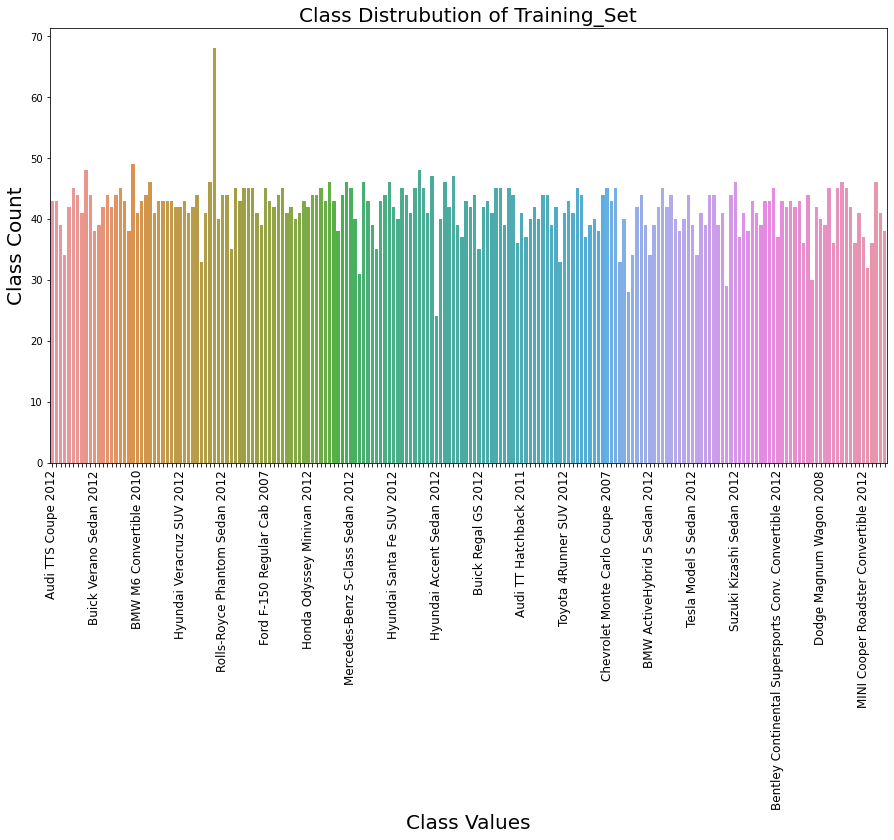

In [10]:
# Class distribution of Training set
plt.figure(figsize = (15, 8))
plot_ = sns.countplot(x = train_df['class'])
plt.title('Class Distrubution of Training_Set', fontsize = 20)
plt.xlabel('Class Values', fontsize = 20)
plt.ylabel('Class Count', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 12)
for ind, label in enumerate(plot_.get_xticklabels()):
  if (ind % 10) == 0:
    label.set_visible(True)
  else:
    label.set_visible(False)
plt.show()

### Validation Set

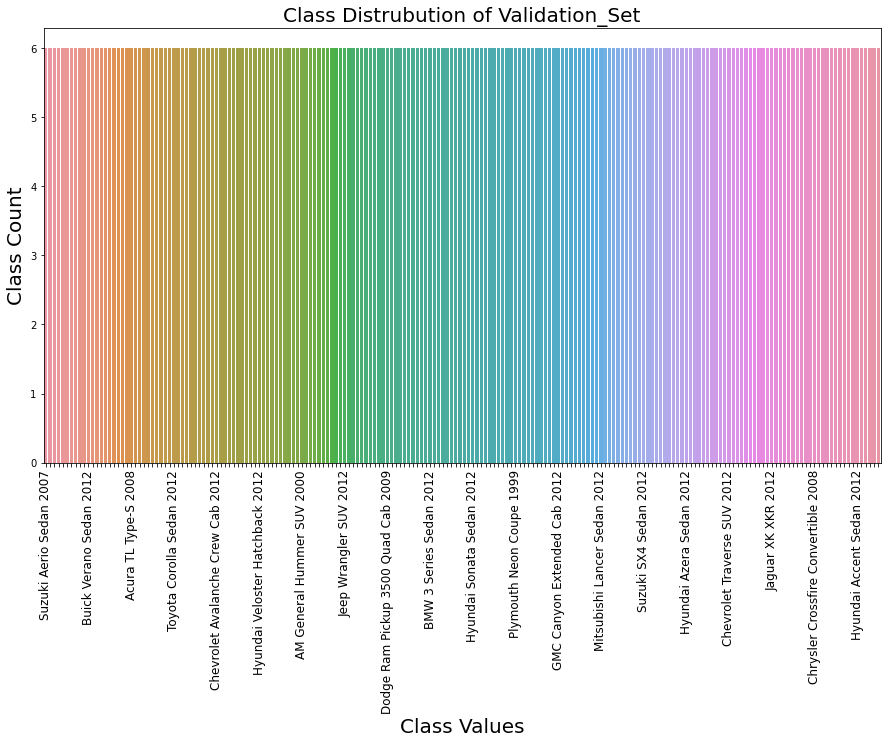

In [11]:
# Class distribution of Validation set
plt.figure(figsize = (15, 8))
plot_ = sns.countplot(x = val_df['class'])
plt.title('Class Distrubution of Validation_Set', fontsize = 20)
plt.xlabel('Class Values', fontsize = 20)
plt.ylabel('Class Count', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 12)
for ind, label in enumerate(plot_.get_xticklabels()):
  if (ind % 10) == 0:
    label.set_visible(True)
  else:
    label.set_visible(False)
plt.show()

### Test Set

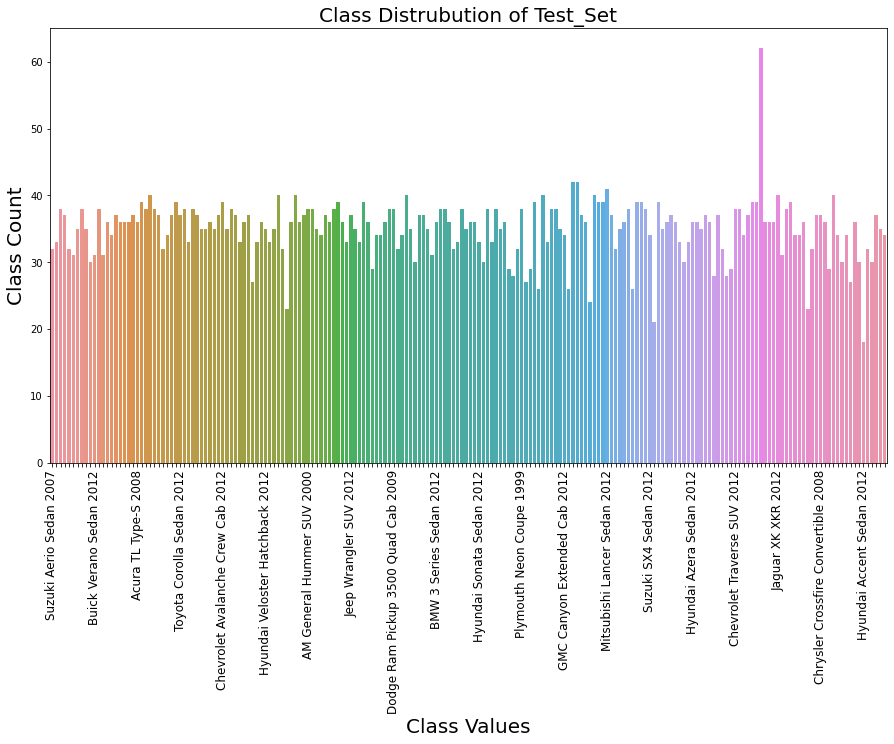

In [12]:
# Class distribution of Test set
plt.figure(figsize = (15, 8))
plot_ = sns.countplot(x = test_df['class'])
plt.title('Class Distrubution of Test_Set', fontsize = 20)
plt.xlabel('Class Values', fontsize = 20)
plt.ylabel('Class Count', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 12)
for ind, label in enumerate(plot_.get_xticklabels()):
  if (ind % 10) == 0:
    label.set_visible(True)
  else:
    label.set_visible(False)
plt.show()

In [13]:
# Collate class frequency counts into a dataframe
train_class_df = train_df['class'].value_counts().to_frame(name = 'Training_Set')
val_class_df = val_df['class'].value_counts().to_frame(name = 'Validation_Set')
test_class_df = test_df['class'].value_counts().to_frame(name = 'Test_Set')
class_df = train_class_df.merge(val_class_df, how = 'left', left_index = True, right_index = True)
class_df = class_df.merge(test_class_df, how = 'left', left_index = True, right_index = True)
class_df.index.set_names(names = 'Car_Class', inplace = True)
display(class_df.head(10))

Training_Set  ...  Test_Set
Car_Class                                               ...          
GMC Savana Van 2012                                 68  ...        62
Chrysler 300 SRT-8 2010                             49  ...        42
Mitsubishi Lancer Sedan 2012                        48  ...        41
Mercedes-Benz 300-Class Convertible 1993            48  ...        42
Chevrolet Corvette ZR1 2012                         47  ...        40
Jaguar XK XKR 2012                                  47  ...        40
Audi S6 Sedan 2011                                  46  ...        40
Volvo 240 Sedan 1993                                46  ...        39
Mercedes-Benz C-Class Sedan 2012                    46  ...        39
Bentley Continental GT Coupe 2007                   46  ...        40

[10 rows x 3 columns]

## Define image folder paths

In [14]:
train_img_path = '/content/train_images/'
val_img_path = '/content/test_images/'
test_img_path = '/content/test_images/'

## Define Function: Visualize Data

In [15]:
def viz_data(name, X, y, X_dtype, mode, num_images, num_cols, col_size, row_size, bm_name = None):

  '''
  Function to plot random images from an input array along with corresponding labels

  Arguments:
    name: Name to print in title (Training_Set, Test_Set etc.)
    X: Image array (should be in (batch, height, width, channel)) format
    y: label array (Raw labels - should not be One-Hot encoded)
    X_dtype: Data Type of image array. One of 'Int' or 'Float'
    mode: One of 'grayscale' or 'color'
    num_images: Number of images to plot from input array
    num_cols: Number of columns to use for plotting
    col_size: Size of columns to use for plotting
    row_size: Size of rows to use for plotting
    bm_name: Name of base model that will be used to undo pre-processing (if required)

  '''

  num_rows = math.ceil(num_images / num_cols) # Number of rows to use for plotting

  fig = plt.figure(figsize = ((num_cols * col_size), (num_rows * row_size)))
  fig.suptitle('Random sample images from ' + name, fontsize = 40)

  # Generate random sample indices
  samp_index = np.random.randint(low = 0, high = X.shape[0], size = num_images).tolist()

  for ind, value in enumerate(samp_index): # Loop through samp_index
    if (X_dtype == 'int'):
      img = (X[value].squeeze()).astype('uint8') # Extract image and force type to uint8
    elif (X_dtype == 'float') :
      if (bm_name == None):
        img = (X[value].squeeze()).astype('float32') # Extract image and force type to float32
      else:
        img = (X[value].squeeze()).astype('float32') # Extract image and force type to float32        
        img = undo_preprocess_data(img, bm_name) # Undo any pre-processing done on image
    label = y[value] # Extract label
    ax = plt.subplot(num_rows, num_cols, (ind + 1))
    if (mode == 'grayscale'):
      ax.imshow(img, cmap = 'gray') # Plot image in grayscale
    elif (mode == 'color'):
      ax.imshow(img) # Plot image in color

    ax.set_title(f"{label}", fontsize = 17)
    ax.grid(False)  

  plt.show()

## Define Function: Visualize Images from DataFrame

In [16]:
def viz_img_df(name, df, x_col, y_col, img_root_path, img_cons, plot_bbox,\
               num_images, num_cols, col_size, row_size):

  '''
  Function to plot random images from an input array along with corresponding labels

  Arguments:
    name: Name to print in title (Training_Set, Test_Set etc.)
    df: Name of dataframe to read image details from
    x_col: Name of column in dataframe that contains file names
    y_col: Name of column in dataframe that contains the class names
    img_root_path: Root directory path where images are stored
    img_cons: Boolean: If True, then all images are assumed to consolidated in img_path (no sub-directories).
                       If False, then the images are assumed to be present inside sub-directories in img_path
                       named with the class name.
    plot_bbox: Boolean: If True, plot bounding-boxes on top of image
                        Should be set to True only if Dataframe has BBOX co-ords                       
    num_images: Number of images to plot from input array
    num_cols: Number of columns to use for plotting
    col_size: Size of columns to use for plotting
    row_size: Size of rows to use for plotting

  '''

  num_rows = math.ceil(num_images / num_cols) # Number of rows to use for plotting

  fig = plt.figure(figsize = ((num_cols * col_size), (num_rows * row_size)))
  fig.suptitle('Random sample images from ' + name, fontsize = 40)

  # Generate random sample indices
  samp_indices = np.random.randint(low = 0, high = df.shape[0], size = num_images).tolist()

  for ind, value in enumerate(samp_indices): # Loop through samp_index
    img_file_name = df.iloc[value][x_col] # Extract file name of image
    img_class = df.iloc[value][y_col] # Extract class of image
    if (img_cons): # img_cons = True -> All images consolidated in img_root_path
      img_file_path = os.path.join(img_root_path, img_file_name) # Obtain full path of image
    else: # img_cons = False -> Each image is present in a sub-directory inside img_root_path
      img_file_path = os.path.join(img_root,path, img_class, img_file_path)
    img = cv2.imread(img_file_path, cv2.IMREAD_COLOR) # Load image using cv2 as a 3-channel RGB image

    if (plot_bbox): # plot_bbox = True => Plot Bounding-Box on top of image
      img_h, img_w = df.iloc[value]['img_h'], df.iloc[value]['img_w'] # Extract image dimensions
      xmin, ymin, xmax, ymax = df.iloc[value]['xmin'], df.iloc[value]['ymin'],\
                               df.iloc[value]['xmax'], df.iloc[value]['ymax'] # Get ground-truth 
                                                                              # BBOX co-ords
      # Set box_thickness based on image area  
      box_thickness = int(np.ceil(((img_h) * (img_w)) / (100000)))
      # Draw ground-truth BBOX in green
      cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), box_thickness)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert image to RGB format
    ax = plt.subplot(num_rows, num_cols, (ind + 1)) # Define plotting axes
    ax.imshow(img) # Plot image in color
    ax.set_title(f"{img_class}", fontsize = 20) # Set title
    ax.grid(False)  

  plt.show()  

## Visualize Data

### Training Set

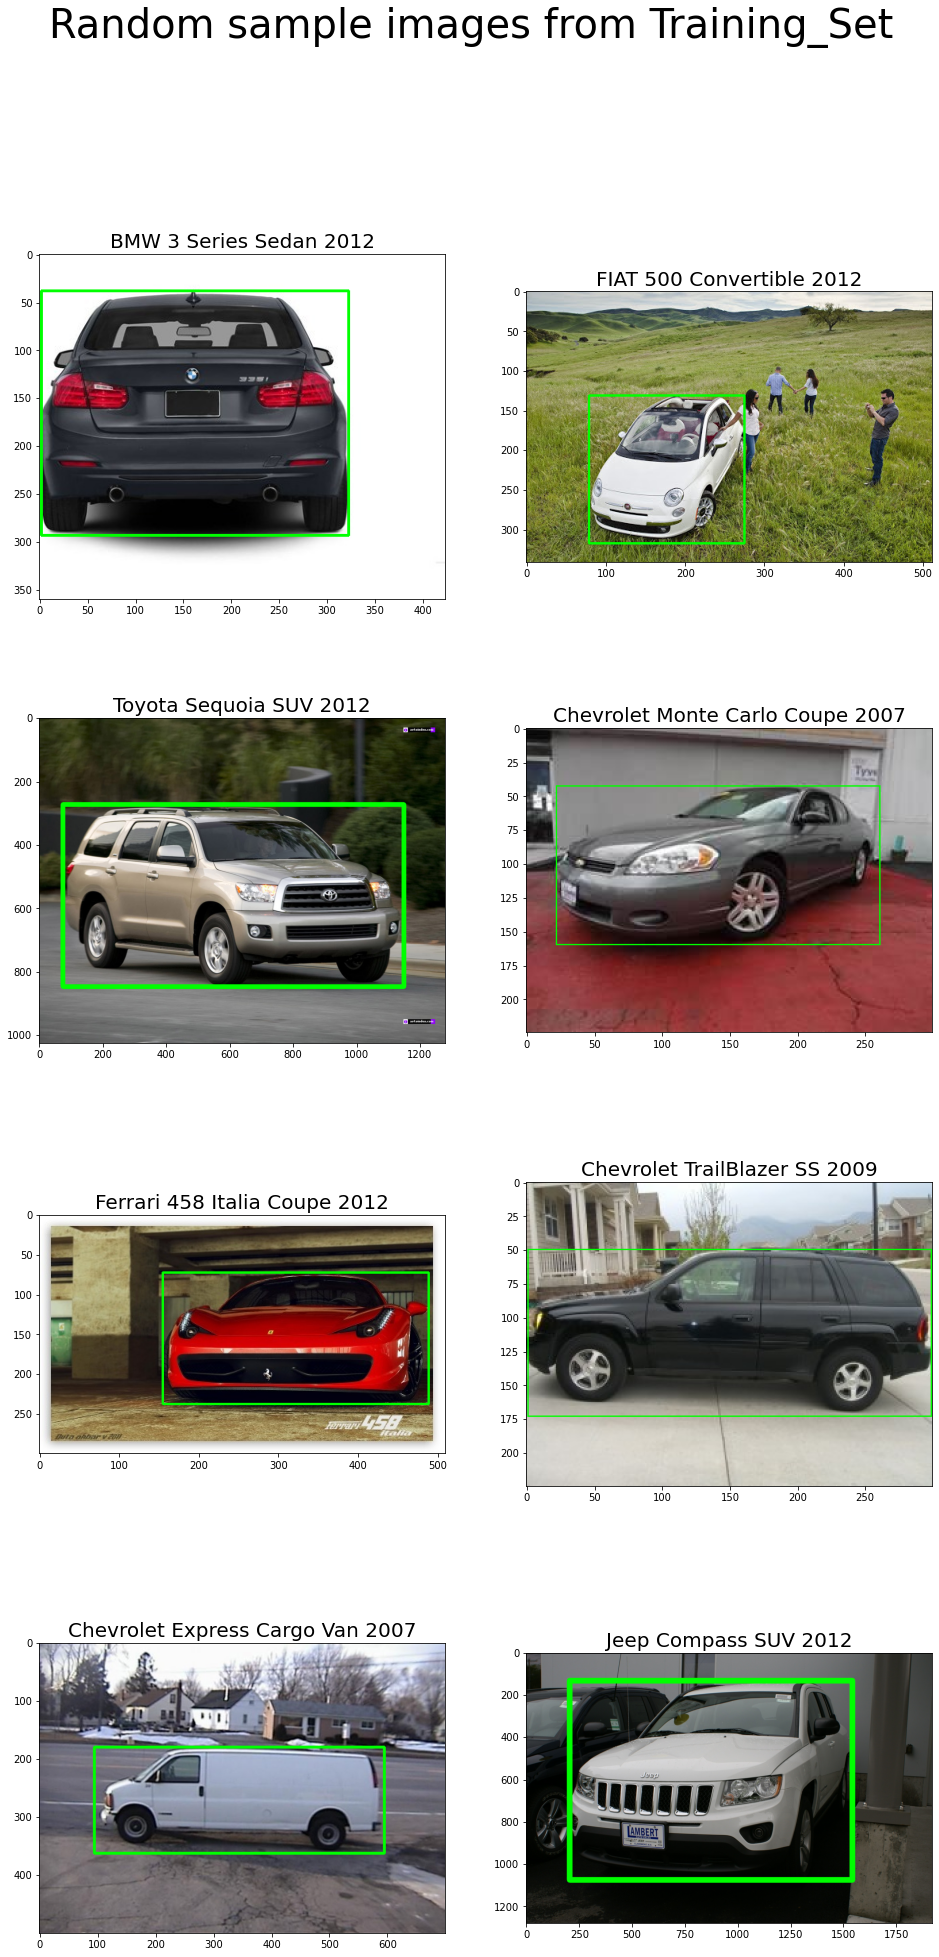

In [17]:
# Plot random images from training set
viz_img_df('Training_Set', train_df, 'filename', 'class', train_img_path, True, True, 8, 2, 8, 8)

### Validation Set

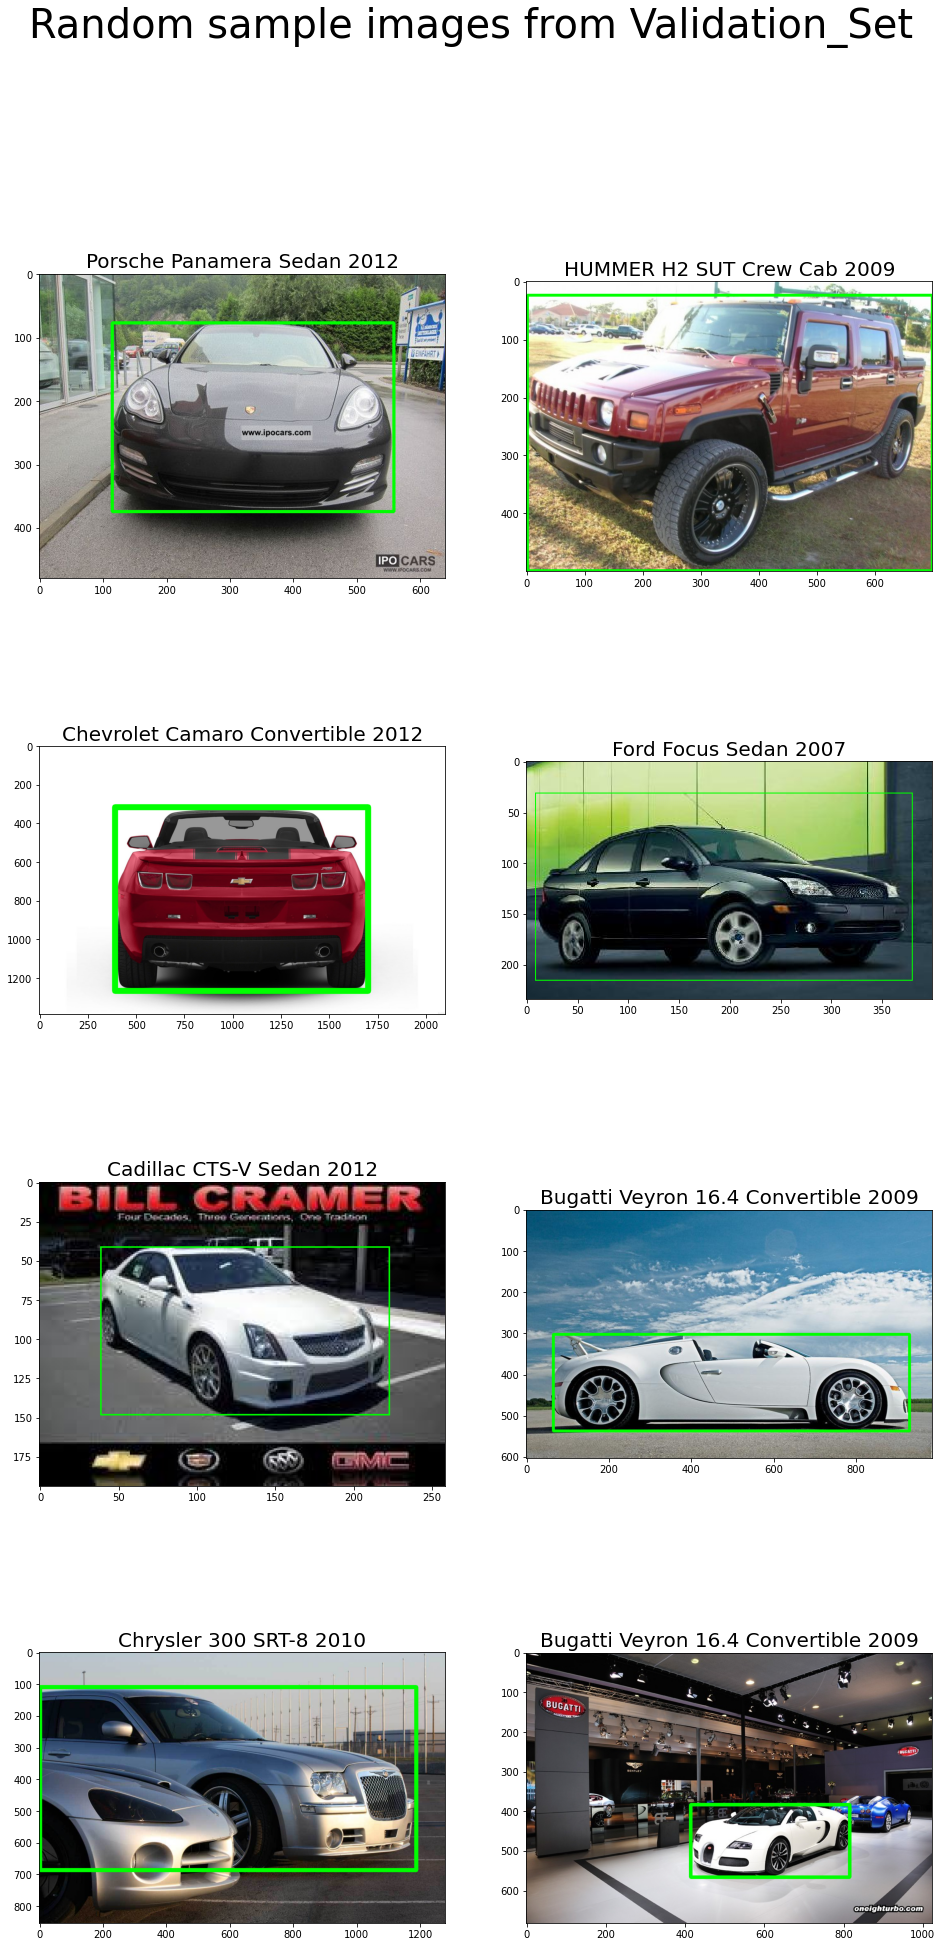

In [18]:
# Plot random images from validation set
viz_img_df('Validation_Set', val_df, 'filename', 'class', val_img_path, True, True, 8, 2, 8, 8)

### Test Set

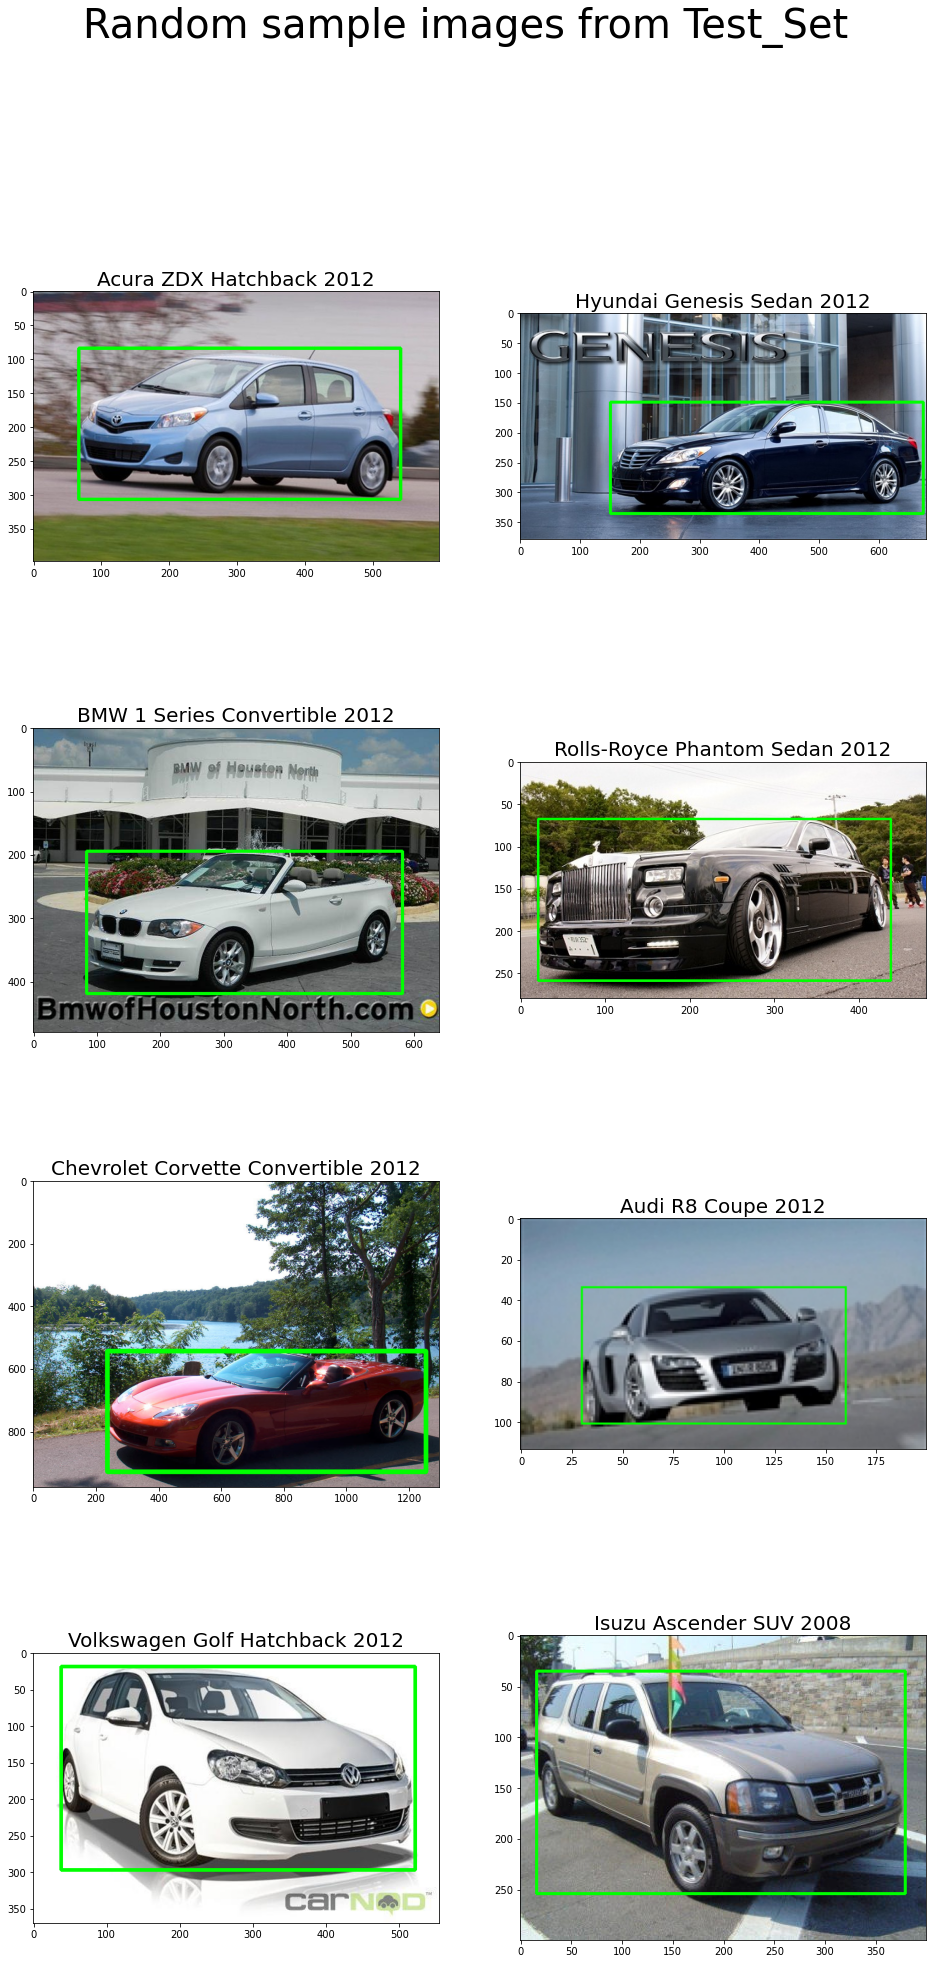

In [19]:
# Plot random images from test set
viz_img_df('Test_Set', test_df, 'filename', 'class', test_img_path, True, True, 8, 2, 8, 8)

# Define Batch Data Generators

## Define Function: plot_img_transf

In [20]:
def plot_img_transf(df, x_col, y_col, img_root_path, img_cons, rot, wid_shift, hgt_shift, shear, zx, zy,\
                    num_cols, col_size, row_size):

  '''
  Function to plot various image transformations on an image before applying these transformations
  for data augmentation

  Arguments:
    df: Name of dataframe to read image details from
    x_col: Name of column in dataframe that contains file names
    y_col: Name of column in dataframe that contains the class names
    img_root_path: Root directory path where images are stored
    img_cons: Boolean: If True, then all images are assumed to consolidated in img_path (no sub-directories).
                       If False, then the images are assumed to be present inside sub-directories in img_path
                       named with the class name.        

    rot: Extent of clockwise-rotation in degrees
    wid_shift: Extent of wid_shift
    hgt_shift: Extent of height shift
    shear: Shear angle in degrees
    zx: Extent of zoom in x-direction
    zy: Extent of zoom in y-direction
    num_cols: Number of columns to use for plotting
    col_size: Size of columns to use for plotting
    row_size: Size of rows to use for plotting

  '''

  # Generate random sample index
  samp_index = np.random.randint(low = 0, high = df.shape[0], size = 1)[0] 
  img_transf = {} # Dict place-holder to store original and transformed images
  img_file_name = df.iloc[samp_index][x_col] # Extract file name of image
  img_class = df.iloc[samp_index][y_col] # Extract class of image
  if (img_cons): # img_cons = True -> All images consolidated in img_root_path
    img_file_path = os.path.join(img_root_path, img_file_name) # Obtain full path of image
  else: # img_cons = False -> Each image is present in a sub-directory inside img_root_path
    img_file_path = os.path.join(img_root,path, img_class, img_file_path)
  img = cv2.imread(img_file_path, cv2.IMREAD_COLOR) # Load image using cv2 as a 3-channel RGB image
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert image to RGB format

  img_transf['Original_Image'] = img # Append original image to img_transf dict
  img_transf['Clockwise_Rotation'] = apply_affine_transform(img, theta = rot) # Clockwise rotn
  img_transf['Anti-clockwise Rotation'] = apply_affine_transform(img, theta = -rot) # Anti-clockwise rotn
  img_transf['Left_Shift'] = apply_affine_transform(img, ty = wid_shift) # Left Shift
  img_transf['Right_Shift'] = apply_affine_transform(img, ty = -wid_shift) # Right Shift
  img_transf['Upward_Shift'] = apply_affine_transform(img, tx = hgt_shift) # Upward Shift
  img_transf['Downward_Shift'] = apply_affine_transform(img, tx = -hgt_shift) # Downward Shift
  img_transf['Shear_Left'] = apply_affine_transform(img, shear = shear) # Left shear
  img_transf['Shear_Right'] = apply_affine_transform(img, shear = -shear) # Righ shear  
  img_transf['Zoom_Y'] = apply_affine_transform(img, zx = zx) # Zoom in x-direction  
  img_transf['Zoom_X'] = apply_affine_transform(img, zy = zy) # Zoom in y-direction    

  num_images = len(img_transf) # Total number of images to plot
  num_rows = math.ceil(num_images / num_cols) # Number of rows to use for plotting
  
  fig = plt.figure(figsize = ((num_cols * col_size), (num_rows * row_size)))
  fig.suptitle('Original image along with some affine transformations', fontsize = 40)

  for ind, dict_entry in enumerate(img_transf.items()): # Loop through dictionary items
    key, image = dict_entry[0], dict_entry[1]
    ax = plt.subplot(num_rows, num_cols, (ind + 1))
    ax.imshow(image) # Plot image in color
    ax.set_title(key, fontsize = 25) # Set key as title
    #ax.grid(False) # Turn off grid

  plt.show()    


## Visualize some image transformations

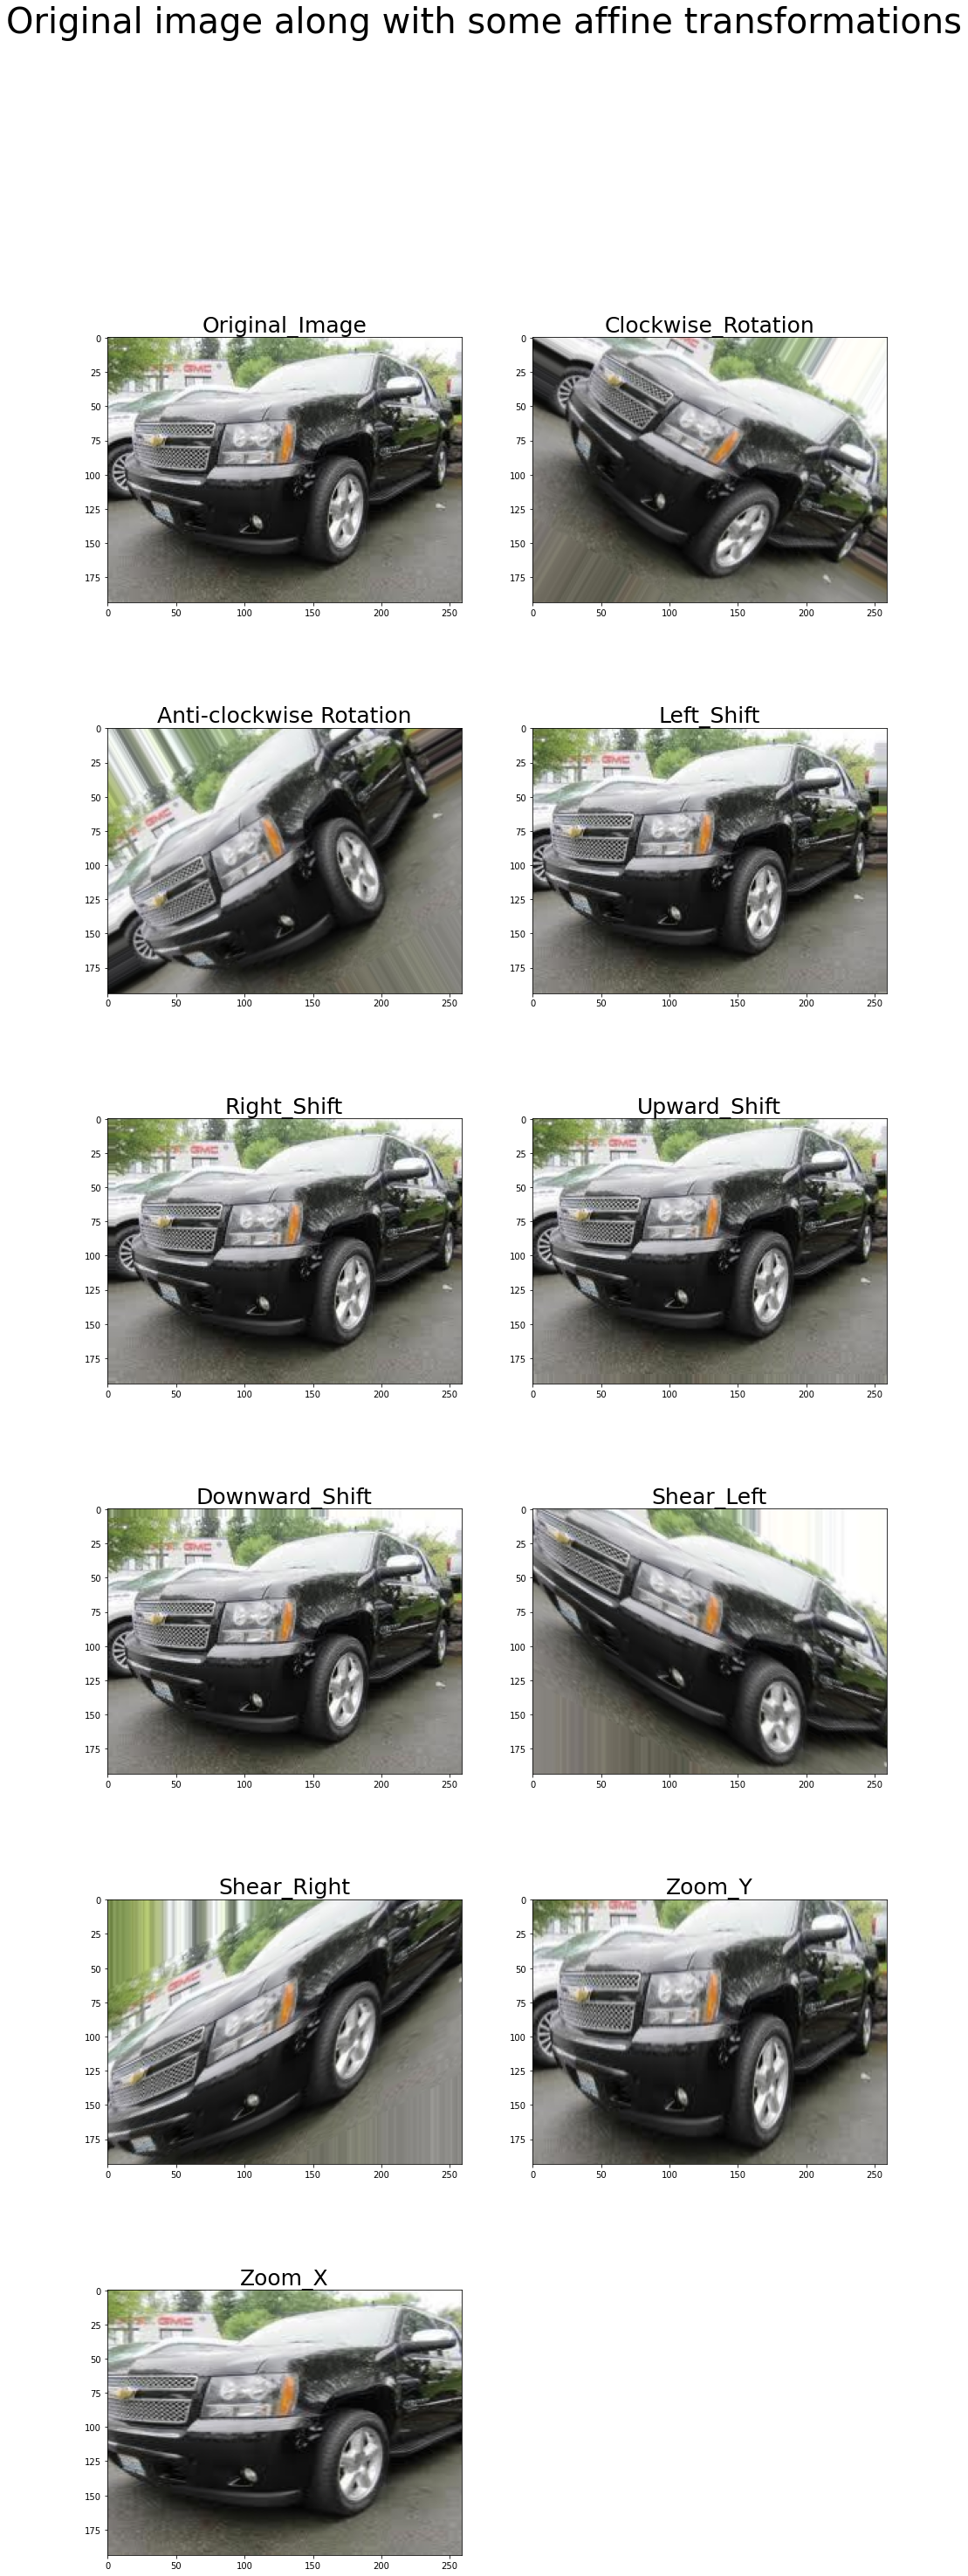

In [21]:
plot_img_transf(train_df, 'filename', 'class', train_img_path, True, rot = 30, wid_shift = 5,\
                hgt_shift = 5, shear = 30, zx = 0.8, zy = 0.8, num_cols = 2, col_size = 8, row_size = 8)

## Define base model, target image shape and model batch size

In [22]:
### The base model defined here (bm_name) will be used to choose the appropriate pre-processing function
### to apply to the input images in the Image Data Generators

### If bm_name = 'VGG16' or 'ResNet50':
###    Only mean shift is applied
###    img_preprocessed = img - [103.939, 116.779, 123.68]
### If bm_name = 'MobileNet' or 'InceptionV3'
###    Image scaled to lie between -1 and +1
###    img_preprocessed = (img / 127.5) - 1
### If bm_name = 'grayscale_model'
###    Image scaled to lie between 0 and +1
###    img_preprocessed = (img / 225.)

# bm_name = 'VGG16'
bm_name = 'ResNet50'
# bm_name = 'MobileNet'
# bm_name = 'InceptionV3'\
# bm_name = 'grayscale_model'

# Define target image size and batch size 
mod_inp_shape = (224, 224, 3) # Define target image size for model input
mod_bat_size = 64 # Batch size to use while model fitting

## Define pre-processing function

In [23]:
# Define pre-processing and undo pre-processing function
# Appropriate pre-processing functions from Keras are used.

def preprocess_data(img):

  if (bm_name == 'VGG16'):
    return vgg16.preprocess_input(img)
  elif (bm_name == 'ResNet50'):
    return resnet50.preprocess_input(img)
  elif (bm_name == 'MobileNet'):
    return mobilenet.preprocess_input(img)
  elif (bm_name == 'InceptionV3'):
    return inception_v3.preprocess_input(img)
  elif (bm_name == 'grayscale_model'):
    return img/255.

def undo_preprocess_data(img, bm_name):

  if ((bm_name == 'VGG16') or (bm_name == 'ResNet50')):
    mean = [103.939, 116.779, 123.68]
    img[..., 0] += mean[0]
    img[..., 1] += mean[1]
    img[..., 2] += mean[2]
    img = img[..., ::-1].astype('uint8')
  elif ((bm_name == 'MobileNet') or (bm_name == 'InceptionV3')):
    img = ((img + 1) * 127.5).astype('uint8')
  elif (bm_name == 'grayscale_model'):
    img = (img * 255.0).astype('uint8')

  return img

## Classes: Define batch generator class

In [32]:
class batch_generator_from_df(Sequence):
    
    def  __init__(self, df, directory, x_col, y_col, batch_size, target_size, shuffle = False, seed = 1234):
      self.df = df
      self.samples = df.shape[0]
      self.directory = directory
      self.x_col = x_col
      self.y_col = y_col
      self.batch_size = batch_size
      self.target_size = target_size
      self.image_shape = (self.target_size[0], self.target_size[1], 3)
      self.shuffle = shuffle
      self.seed = seed
      self.class_list = sorted(df[y_col].unique())
      self.num_classes = len(self.class_list)
      self.class_indices = {value:ind for ind, value in enumerate(self.class_list)}
      self.on_epoch_end()
      print(f"Found {self.samples} images belonging to {self.num_classes} classes")

    def __len__(self):
      return int(np.ceil(float(self.df.shape[0] / self.batch_size)))

    def __getitem__(self, index):
      start_ind = index * self.batch_size # Start index of current batch
      end_ind = min((index + 1) * self.batch_size, self.df.shape[0]) # End index of current batch
      sub_df = self.df[start_ind:end_ind] # Create sub dataframe using start and end indices
      X_batch = []
      y_batch = []
      for _, row in sub_df.iterrows():
        img_file_name = row[self.x_col]
        img_file_path = os.path.join(self.directory, img_file_name)
        img = cv2.imread(img_file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.target_size[0], self.target_size[1]), interpolation = cv2.INTER_CUBIC)
        X_batch.append(img)
        label = row[self.y_col]
        label_index = self.class_indices[label]
        label_ohe = to_categorical(label_index, num_classes = self.num_classes)
        y_batch.append(label_ohe)
      X_batch = np.array(X_batch, dtype = np.float32)
      y_batch = np.array(y_batch, dtype = np.int)
      
      return X_batch, y_batch

    def on_epoch_end(self):
      if (self.shuffle): # If 'shuffle' = True, random shuffle the dataframe at the end of the epoch
        self.df = self.df.sample(frac = 1).reset_index(drop = True)

## Define Image Data Generators

In [25]:
# Define train, val and test ImageDataGenerator objects
# Train ImageDataGenerator includes image augmentation
# Val and Test ImageDataGenerators don't have any image augmentation

# train_datagen = ImageDataGenerator(preprocessing_function = preprocess_data)
# train_datagen = ImageDataGenerator(rotation_range = 15, horizontal_flip = True, width_shift_range = 0.2,\
#                                    height_shift_range = 0.2, shear_range = 15, zoom_range = 0.2,\
#                                    channel_shift_range = 20.0, preprocessing_function = preprocess_data)
# val_datagen = ImageDataGenerator(preprocessing_function = preprocess_data)
# test_datagen = ImageDataGenerator(preprocessing_function = preprocess_data)

## Define Generator Objects

In [33]:
# Define train, val and test generator objects
# train_generator = train_datagen.flow(X_train, y_train_ohe, batch_size = mod_bat_size,\
#                                      shuffle = True, seed = 1234)

# train_generator = train_datagen.flow_from_dataframe(train_df, directory = train_img_path,\
#                                                     x_col = "filename", y_col = "class",\
#                                                     target_size = mod_inp_shape[0:2],\
#                                                     class_mode = 'categorical', batch_size = mod_bat_size,\
#                                                     shuffle = True, seed = 1234, interpolation = "bicubic")
# val_generator = val_datagen.flow_from_dataframe(val_df, directory = test_img_path,\
#                                                 x_col = "filename", y_col = "class",\
#                                                 target_size = mod_inp_shape[0:2],\
#                                                 class_mode = 'categorical', batch_size = mod_bat_size,\
#                                                 shuffle = True, seed = 1234, interpolation = "bicubic")
# test_generator = test_datagen.flow_from_dataframe(test_df, directory = test_img_path,\
#                                                   x_col = "filename", y_col = "class",\
#                                                   target_size = mod_inp_shape[0:2],\
#                                                   class_mode = 'categorical', batch_size = mod_bat_size,\
#                                                   shuffle = True, seed = 1234, interpolation = "bicubic")
train_generator = batch_generator_from_df(train_df, train_img_path, 'filename', 'class', 5,\
                                          mod_inp_shape[0:2])
val_generator = batch_generator_from_df(val_df, test_img_path, 'filename', 'class', 5,\
                                        mod_inp_shape[0:2])
test_generator = batch_generator_from_df(test_df, test_img_path, 'filename', 'class', 5,\
                                        mod_inp_shape[0:2])

Found 8144 images belonging to 196 classes
Found 1176 images belonging to 196 classes
Found 6865 images belonging to 196 classes


## Verify generator objects

In [35]:
# Print some details of train, val and test generators
num_classes = len(train_generator.class_indices)
num_batches_train = len(train_generator)
num_batches_val = len(val_generator)
num_batches_test = len(test_generator)

print("Train_Generator_Information:")
print("----------------------------")
print(f"Total number of samples: {train_generator.samples}")
print(f"Number of classes: {num_classes}")
print(f"Size of each batch: {train_generator.batch_size}")
print(f"Shape of images: {train_generator.image_shape}")
print(f"Number of batches: {num_batches_train}")
print()

print("Val_Generator_Information:")
print("----------------------------")
print(f"Total number of samples: {val_generator.samples}")
print(f"Size of each batch: {val_generator.batch_size}")
print(f"Shape of images: {val_generator.image_shape}")
print(f"Number of batches: {num_batches_val}")
print()

print("Test_Generator_Information:")
print("----------------------------")
print(f"Total number of samples: {test_generator.samples}")
print(f"Size of each batch: {test_generator.batch_size}")
print(f"Shape of images: {test_generator.image_shape}")
print(f"Number of batches: {num_batches_test}")

Train_Generator_Information:
----------------------------
Total number of samples: 8144
Number of classes: 196
Size of each batch: 5
Shape of images: (224, 224, 3)
Number of batches: 1629

Val_Generator_Information:
----------------------------
Total number of samples: 1176
Size of each batch: 5
Shape of images: (224, 224, 3)
Number of batches: 236

Test_Generator_Information:
----------------------------
Total number of samples: 6865
Size of each batch: 5
Shape of images: (224, 224, 3)
Number of batches: 1373


In [36]:
# Extract class-index mapping from train generator
class_ind_dict = train_generator.class_indices
# Create index-class mapping from class-index mapping
ind_class_dict = {value:ind for ind, value in class_ind_dict.items()}

for ind, class_val in ind_class_dict.items():
  if (ind < 10):
    print(f"Index: {ind}, Class: {class_val}")

Index: 0, Class: AM General Hummer SUV 2000
Index: 1, Class: Acura Integra Type R 2001
Index: 2, Class: Acura RL Sedan 2012
Index: 3, Class: Acura TL Sedan 2012
Index: 4, Class: Acura TL Type-S 2008
Index: 5, Class: Acura TSX Sedan 2012
Index: 6, Class: Acura ZDX Hatchback 2012
Index: 7, Class: Aston Martin V8 Vantage Convertible 2012
Index: 8, Class: Aston Martin V8 Vantage Coupe 2012
Index: 9, Class: Aston Martin Virage Convertible 2012


## Visualize the data from generator objects

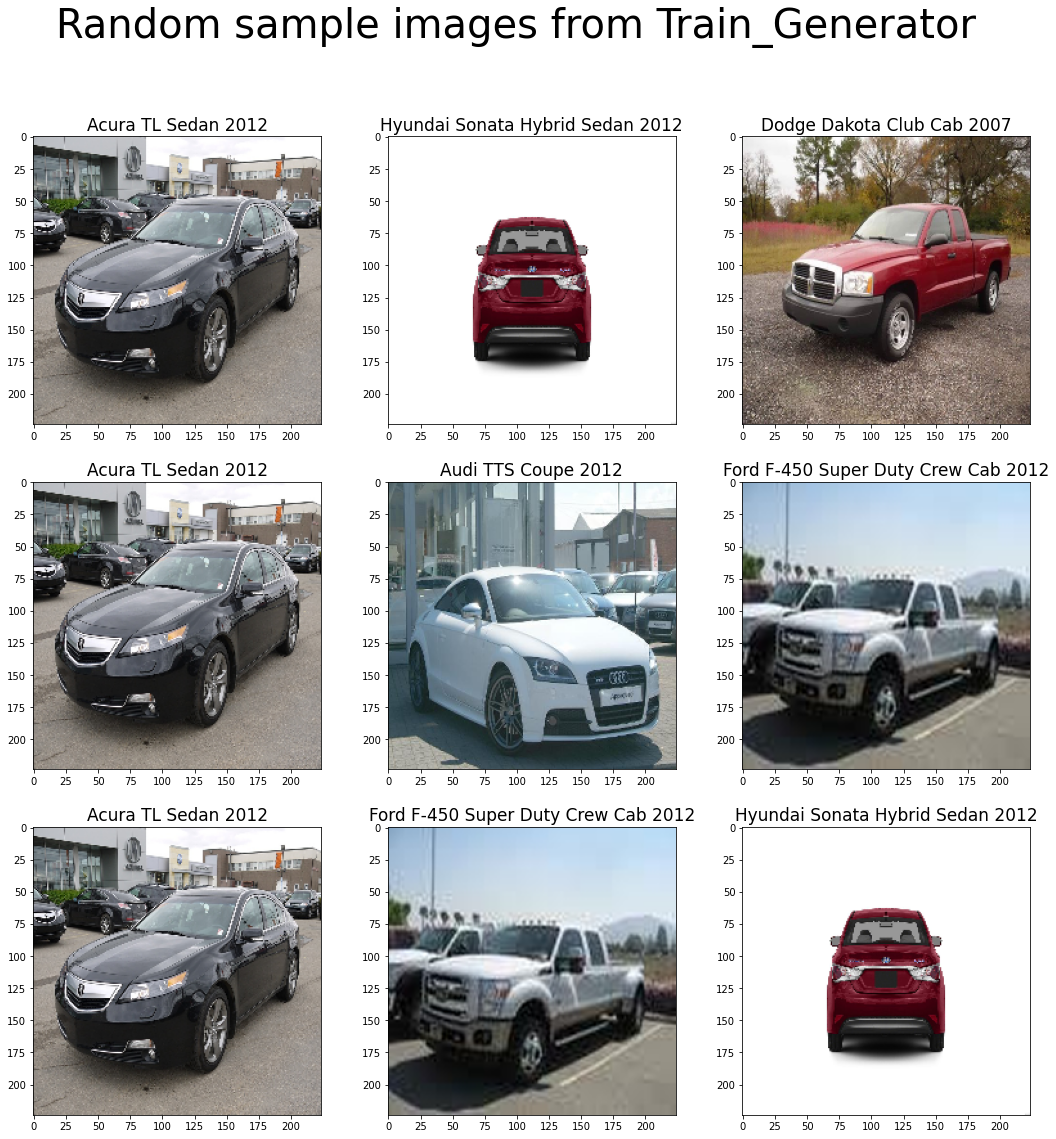

In [44]:
# Generate a batch of data from train_generator
X_batch, y_batch = train_generator.__getitem__(0)
y_batch = np.argmax(y_batch, axis = 1)
label = [ind_class_dict[y] for y in y_batch]
viz_data('Train_Generator', X_batch, label, 'int', 'color', num_images = 9, num_cols = 3,\
         col_size = 6, row_size = 6, bm_name = None)
print("\n\n")
# # Generate a batch of data from validation_generator
# X_batch, y_batch = next(val_generator)
# y_batch = np.argmax(y_batch, axis = 1)
# label = [ind_class_dict[y] for y in y_batch]
# viz_data('Val_Generator', X_batch, label, 'float', 'color', num_images = 9, num_cols = 3,\
#          col_size = 6, row_size = 6, bm_name = bm_name)
# print("\n\n")
# # Generate a batch of data from test_generator
# X_batch, y_batch = next(test_generator)
# y_batch = np.argmax(y_batch, axis = 1)
# label = [ind_class_dict[y] for y in y_batch]
# viz_data('Test_Generator', X_batch, label, 'float', 'color', num_images = 9, num_cols = 3,\
#          col_size = 6, row_size = 6, bm_name = bm_name)
# print("\n\n")

# Models - Build, Train, Tune

## Functions

### Define Model Core

In [ ]:
def model_core(model_dict):
    
    """
    Function to define the model core.
    
    Arguments:
      model_dict - Dictionary with list of keys / values needed to build the model

    Returns:
      model - Model with all layers instantiated
 
    """    
    # Retrieve model dict parameters
    model_arch = model_dict['model_arch'] # Model Architecture

    ##### Start Model Architecture A (VGG16 Base)
    if (model_arch == 'A'):
        # Retrieve arch. specific model dict parameters
        mod_inp_shape = model_dict['mod_inp_shape'] # Shape of input tensor to model
        weights = model_dict['weights'] 
        trainable = model_dict['trainable']
        dropout_rate = model_dict['dropout_rate']
        num_classes = model_dict['num_classes']
        
        base_model = resnet50.ResNet50(input_shape = mod_inp_shape, weights = weights,\
                                 include_top = False, pooling = 'avg')
        for layer in base_model.layers:
            layer.trainable = trainable
            
        X = base_model.output
        X = Flatten()(X)
        X = Dropout(rate = dropout_rate[0], name = 'DR0')(X)        
        X = Dense(1024, activation = 'relu')(X)        
        X = Dropout(rate = dropout_rate[1], name = 'DR1')(X)
        X = Dense(512, activation = 'relu')(X)        
        X = Dropout(rate = dropout_rate[2], name = 'DR2')(X)
        label_output = Dense(num_classes, activation = 'softmax', name = 'class_op')(X) 

        # # # Add output layer for bounding box regression
        # bbox_output = Dense(4, activation = 'sigmoid', name = 'reg_op')(X)        
        
        # model = Model(inputs = base_model.input, outputs = [label_output, bbox_output])
        model = Model(inputs = base_model.input, outputs = label_output)
        
    ##### End Model Architecture A 

    ##### Start Model Architecture C (Inception Base)
    if (model_arch == 'C'):
        # Retrieve arch. specific model dict parameters
        mod_inp_shape = model_dict['mod_inp_shape'] # Shape of input tensor to model
        weights = model_dict['weights'] 
        trainable = model_dict['trainable']
        dropout_rate = model_dict['dropout_rate']
        num_classes = model_dict['num_classes']
        
        base_model = inception_v3.InceptionV3(input_shape = mod_inp_shape, weights = weights,\
                                 include_top = False, pooling = 'avg')
        for layer in base_model.layers:
            layer.trainable = trainable
            
        X = base_model.output
        X = Flatten()(X)
        X = Dropout(rate = dropout_rate[0], name = 'DR0')(X)        
        X = Dense(1024, activation = 'relu')(X)        
        X = Dropout(rate = dropout_rate[1], name = 'DR1')(X)
        X = Dense(512, activation = 'relu')(X)        
        X = Dropout(rate = dropout_rate[2], name = 'DR2')(X)
        label_output = Dense(num_classes, activation = 'softmax', name = 'class_op')(X) 

        # # # Add output layer for bounding box regression
        # bbox_output = Dense(4, activation = 'sigmoid', name = 'reg_op')(X)        
        
        # model = Model(inputs = base_model.input, outputs = [label_output, bbox_output])
        model = Model(inputs = base_model.input, outputs = label_output)
        
    ##### End Model Architecture C        
    
    return model

### Verify Model Core

In [ ]:
# Verify model defined above
model_dict = {'model_arch': 'A',
              'mod_inp_shape': mod_inp_shape,
              'weights': 'imagenet',
              'trainable': True,
              'dropout_rate': [0.2, 0.2, 0.1],
              'num_classes': num_classes
              }
temp_model = model_core(model_dict)
temp_model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_____________________________

### Define Model_Compile

In [ ]:
def model_compile(model, compile_dict):
    
    """
    Function to compile the model
    
    Arguments:
      model - Model instance that needs to be compiled
      compile_dict - Dictionary with list of keys / values needed to compile the model
 
    """    
    # Retrieve compile_dict parameters
    ilr = compile_dict['ilr'] # Initial learning rate to use for learning rate decay scheduler    
    dr = compile_dict['dr'] # Decay rate to use for learning rate decay scheduler    
    ds = compile_dict['ds'] # Decay step to use for learning rate decay scheduler
    redlr_plat = compile_dict['redlr_plat'] # Boolean: If True, implement reduce LR on plateau     

    lr_sch = InverseTimeDecay(ilr, ds, dr) # Inverse Time Decay LR scheduler
    # Define Optimizer
    if (redlr_plat):
      opt = optimizers.Adam(learning_rate = ilr) 
    else:
      opt = optimizers.Adam(learning_rate = lr_sch)
    loss = losses.CategoricalCrossentropy() # Define loss
    met = [metrics.CategoricalAccuracy()] # Define metric

    # Compile model
    model.compile(optimizer = opt, loss = loss, metrics = met)

### Define Model_Fit

In [ ]:
def model_fit(model, train_dict):
    
    """
    Function to fit the model
    
    Arguments:
      model - Model instance that needs to be trained
      train_dict - Dictionary with list of keys / values needed to fit the model      

    Returns:
      model - Final trained model
      hist - Model training history
    """   

    # Retrieve path parameters
    tb_path = train_dict['tb_path'] # Path to store Tensorboard callback information
    mc_path = train_dict['mc_path'] # File name to use for storing model checkpoints
    
    # Retrieve callback parameters
    mcp_freq = train_dict['mcp_freq'] # Number of batches after which model will be checkpointed    
    early_stop = train_dict['early_stop'] # Boolean: If True, implement early stop
    redlr_plat = train_dict['redlr_plat'] # Boolean: If True, implement reduce LR on plateau  
    lrpl_fac = train_dict['lrpl_fac'] # Factor to use for Reduce LR on Plateau callback
    lrpl_pat = train_dict['lrpl_pat'] # Patience to use for Reduce LR on Plateau callback    

    # Retrieve training parameters
    train_gen = train_dict['train_gen'] # Train Generator to use while fitting
    val_data = train_dict['val_gen'] # Validation Generator to use while fitting
    epochs = train_dict['epochs'] # Number of epochs to train for
    initial_epoch = train_dict['initial_epoch'] # Initial epoch to re-start training from
    train_steps_per_epoch = train_dict['train_steps_per_epoch'] # Number of steps per training epoch
    val_steps = train_dict['val_steps'] # Number of steps before stopping validation
    val_freq = train_dict['val_freq'] # Number of epochs to run before performing a validation run
    verb = train_dict['verb'] # Controls verbosity level of model fit.

    #### Start -  Define callbacks
    # Define path for tensorboard logs
    logdir = os.path.join(tb_path,\
                          datetime.datetime.now(pytz.timezone('Asia/Kolkata')).strftime("%d%m_%H%M"))
    # Define Tensorboard callback
    tensorboard_callback = TensorBoard(logdir, histogram_freq = 0)
    # Define Model Checkpoint callback
    mcp_callback = ModelCheckpoint(filepath = mc_path, monitor = "val_loss", save_freq = mcp_freq,\
                                   verbose = 0, save_best_only = True)
    # Define Early Stopping callback
    earlystopping_callback = EarlyStopping(monitor = "val_loss", min_delta = 0, patience = 15,\
                                           mode = "min", verbose = 1)
    # Define 'Reduce learning rate on plateau' callback
    redlr_plat_callback = ReduceLROnPlateau(monitor = "val_loss", factor = lrpl_fac, patience = lrpl_pat,\
                                            verbose = 1, mode = "min", min_delta = 0.0001)
    # Define list of all callbacks
    callback_list = []
    if (tb_path != None): callback_list.append(tensorboard_callback)
    if (mc_path != None): callback_list.append(mcp_callback)
    if (early_stop): callback_list.append(earlystopping_callback)    
    if (redlr_plat): callback_list.append(redlr_plat_callback)
    #### End -  Define callbacks 
    
    #### Start - Model Fit
    hist = model.fit(x = train_gen, validation_data = val_data, epochs = epochs,\
                     initial_epoch = initial_epoch, steps_per_epoch = train_steps_per_epoch,\
                     validation_steps = val_steps, validation_freq = val_freq,
                     callbacks = callback_list, verbose = verb)
    #### End - Model Fit   

    return model, hist

### Define Model_Train

In [ ]:
def model_train(model_dict, compile_dict, train_dict, model = None):
  """
  Function to instantiate (or load) model, compile and fit model.
    
  Arguments:
    model_dict - Dictionary with list of keys / values needed to build the model
    compile_dict - Dictionary with list of keys / values needed to compile the model
    train_dict - Dictionary with list of keys / values needed to train the model
    model - Pre-trained model (Pass this as input only if fit_resume = True and load_model = False)
    
  Returns:
    model - Final trained model
    hist - Model training history
 
  """   
  # Retrieve train_dict parameters
  fit_resume = train_dict['fit_resume'] # Boolean: If True, resume fit from initial epoch
  load_model = train_dict['load_model'] # Boolean: If True, load model from 'fm_path' and resume fit  
  recompile = train_dict['recompile'] # Boolean: If True, recompile model before resuming fit  
  fm_path = train_dict['fm_path'] # File name to use for storing final trained model
  hi_path = train_dict['hi_path'] # File name to use for storing training history

  if (not(fit_resume)): # fit_resume = False => instantiating new model
    print("Instantiating new model...", end = ', ')
    model = model_core(model_dict) # Instantiate new model
    print("Compiling model...", end = ', ')
    model_compile(model, compile_dict) # Compile model
    print("Model Fit started....", end = ', ')    
    model, hist = model_fit(model, train_dict) # Fit model
  else: # fit_resume = True => Proceed with existing model in memory or load model from disk
    if (load_model): # load_model = True => Load model from disk
      print("Loading model from disk...", end = ', ')
      model = models.load_model(fm_path) # Reload model from disk
      if (recompile): # Re-compile model if "recompile" = True
        print("Re-Compiling model...", end = ', ')
        model_compile(model, compile_dict) 
      print("Resuming model fit....", end = ', ')
      model, hist = model_fit(model, train_dict) # Resume model fit
    else: # load_model = False => Proceed with existing model in memory
      if (recompile): # Re-compile model if "recompile" = True
        print("Re-compiling model...", end = ', ')
        model_compile(model, compile_dict)
      print("Resuming model fit....", end = ', ')
      model, hist = model_fit(model, train_dict) # Resume model fit

  # Save final trained model and history to file
  if (fm_path != None): model.save(fm_path, overwrite = True, save_format = 'h5') 
  if (hi_path != None): np.save(hi_path, hist.history)

  return model, hist

## Classes

### Define HyperModel Class (For Hyperparameter Tuning)

In [ ]:
class MyHyperModel(HyperModel):

  def __init__(self, model_dict, compile_dict, hp_dict):
    self.model_dict_tune = model_dict.copy() # Dictionary of default model parameters
    self.compile_dict_tune = compile_dict.copy() # Dictionary of default compilation parameters
    self.hp_dict = hp_dict # Dictionary of hyperparameters to tune

  def build(self, hp):
    hp_list = [] # List placeholder to define all hyperparameters
    for ind in range(len(hp_dict)): # Update hp_list based on hp_dict
      if (hp_dict[ind][0] == 'choice'): hp_list.append(hp.Choice(name = hp_dict[ind][1],\
                                                                 values = hp_dict[ind][2],\
                                                                 ordered = hp_dict[ind][3]))    
    # Set hyperparameters in model_dict_tune
    self.model_dict_tune['dropout_rate'] = [hp_list[0], hp_list[1]]

    model = model_core(self.model_dict_tune) # Instantiate model
    model_compile(model, self.compile_dict_tune) # Compile model    
   
    return model

## Set model_core, model_compile, model_train parameters

In [ ]:
### Define file paths
mod_file_pref = "MA_8" # Prefix to use for naming files and paths
tb_path = os.path.join(tb_logs_base_path, mod_file_pref) # Tensorboard base path
fm_path = os.path.join(out_base_path, mod_file_pref + "_finalmodel.h5") # Final trained model path
#mc_path = os.path.join(out_base_path, mod_file_pref + "_EP{epoch:04d}.h5") # Model checkpoints path
mc_path = os.path.join("/content", mod_file_pref + ".h5") # Model checkpoints path
hi_path = os.path.join(out_base_path, mod_file_pref + "_hist.npy") # Training history path

# Set model_dict values
model_dict = {'model_arch': 'A',
              'mod_inp_shape': mod_inp_shape,
              'weights': 'imagenet',
              'trainable': True,
              'dropout_rate': [0.4, 0.7, 0.2],
              'num_classes': num_classes
              }
# Set compile_dict values
compile_dict = {'ilr': 5e-4, # Initial learning rate to use for learning rate decay scheduler    
                'dr': 0, # Decay rate to use for learning rate decay scheduler
                'ds': (len(train_generator) * 10), # Decay rate to use for learning rate decay scheduler
                'redlr_plat': False, # Boolean: If True, implement reduce LR on plateau  
               }
# Set train_dict values               
train_dict = {'fit_resume': False, # Boolean: If True, resume fit from initial epoch
              'load_model': False, # Boolean: If True, load model from 'fm_path' and resume fit
              'recompile': False, # Boolean: If True, recompile model before resuming fit
              'train_gen': train_generator, # Train generator to use while fitting
              'val_gen': val_generator, # Validation generator to use while fitting
              'epochs': 200, # Number of epochs to train for              
              'initial_epoch': 0, # Initial epoch to start from              
              'train_steps_per_epoch': len(train_generator), # No. of steps per epoch
              'val_steps': len(val_generator), # No. of steps before stopping eval of val set
              'val_freq': 1, # Number of epochs to run before performing a validation run
              'verb': 1, # Controls verbosity level of model fit.
              'mcp_freq': "epoch", # Checkpoint model after mcp_freq batches
              'early_stop': True, # Boolean: If True, implement early stop
              'redlr_plat': compile_dict['redlr_plat'], # Boolean: If True, implement reduce LR on plateau
              'lrpl_fac': 0.5, # Factor to use for Reduce LR on Plateau callback
              'lrpl_pat': 10, # Patience to use for Reduce LR on Plateau callback              
              'tb_path': tb_path, # Path to store Tensorboard callback information
              'mc_path': mc_path, # File name to use for storing model checkpoints
              'fm_path': fm_path, # File name to use for storing final trained model
              'hi_path': hi_path, # File name to use for storing training history
              }

print(tb_path)
print(mc_path)
print(fm_path)
print(hi_path)

/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/Stanford_Car_Dataset/TB_Logs/MA_8
/content/MA_8.h5
/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/Stanford_Car_Dataset/Training_Outputs/MA_8_finalmodel.h5
/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/Stanford_Car_Dataset/Training_Outputs/MA_8_hist.npy


## Launch Tensorboard

In [ ]:
%tensorboard --logdir {tb_logs_base_path}

## Train Model

In [ ]:
# Get start time of run and display it
start_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
print("Started at %s" %(start_time.strftime("%H:%M:%S")), end = '; ')

# Instantiate, compile and fit model
if (train_dict['fit_resume'] and not(train_dict['load_model'])):
  model, hist = model_train(model_dict, compile_dict, train_dict, model)
else:
  model, hist = model_train(model_dict, compile_dict, train_dict)

# Get end time of run and display elapsed time
end_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
elap_time = ((end_time - start_time).total_seconds())/60
print("\nCompleted at %s. Elapsed time = %0.2f minutes." %(end_time.strftime("%H:%M:%S"), elap_time))

In [ ]:
# Copy best model to drive
model_path = os.path.join(out_base_path, mod_file_pref + "_bestmodel.h5")
!cp /content/MA_8.h5 {model_path}
!rm /content/MA_8.h5

## Hyperparameter Tuning

In [ ]:
project_name = "MA_DR_Tune" # Directory to store results of hyperparameter tuning

# Define hyperparameters in hp_dict
hp_dict = {0: ['choice', 'Dropout_0', [0.2, 0.3, 0.4, 0.5], True],
           1: ['choice', 'Dropout_1', [0.2, 0.3, 0.4, 0.5], True],
           }

# Instantiate hypermodel           
hypermodel = MyHyperModel(model_dict, compile_dict, hp_dict) 

# Instantiate Tuner
tuner = kt.RandomSearch(hypermodel, objective = 'val_categorical_accuracy', max_trials = 2,\
                        seed = 1234, directory = kt_logs_base_path, project_name = project_name)

# Display Hyperparameter Search Space
tuner.search_space_summary()

In [ ]:
# Run hyperparameter search
tuner.search(x = train_dict['train_gen'], validation_data = train_dict['val_gen'],\
             epochs = 2, steps_per_epoch = train_dict['train_steps_per_epoch'],\
             validation_steps = train_dict['val_steps'], verbose = 1)

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0].get_config()['values']
print()
print("Best Hyperparameters:")
print("---------------------")
print(best_hps)

# best_hps_dict = tuner.get_best_hyperparameters(num_trials = 1)[0]
# best_model = tuner.hypermodel.build(best_hps_dict)
# best_model.summary()

# Results Summary

## Define Functions

### Function: get_model

In [ ]:
def get_model(mod_file_prefix, best_model, print_summary = False):
  '''
  Function to return required paths, loaded model and print model summary

  Arguments:
    mod_file_prefix: # Prefix of model file name
    best_model: Boolean. If True, load best_model, else load final model
    print_summary: Boolean. If True, print model summary
  '''
  fm_path = os.path.join(out_base_path, mod_file_pref + "_finalmodel.h5") # Final model path
  bm_path = os.path.join(out_base_path, mod_file_pref + "_bestmodel.h5")
  hi_path = os.path.join(out_base_path, mod_file_pref + "_hist.npy") # History file path
  
  # Load model with final trained weights
  if (best_model): # best_model = True => Load best model
    model = models.load_model(bm_path) 
  else: # best_model = False => Load final model
    model = models.load_model(fm_path) 

  # Print model summary
  if (print_summary):
    display(model.summary())

  return fm_path, hi_path, model

### Function: plot_lc

In [ ]:
def plot_lc(mod_file_pref, hi_path, hist_plot_dict, num_cols, col_size, row_size):
  '''
  Function to plot learning curves 

  Arguments:
    hi_path: path of history file
    hist_plot_dict: Dictionary containing items to plot
    num_cols: Number of columns to use for plotting
    col_size: Column width to use while plotting
    row_size: Row width to use while plotting
  '''
  hist_model = np.load(hi_path, allow_pickle = 'TRUE').item()
  
  num_plots = len(hist_plot_dict)
  num_rows = math.ceil(num_plots / num_cols) # Number of rows to use for plotting

  fig = plt.figure(figsize = ((num_cols * col_size), (num_rows * row_size)))
  fig.suptitle(mod_file_pref + " Learning Curves", fontsize = 20)

  for ind, value in enumerate(hist_plot_dict.items()):
    ax = plt.subplot(num_rows, num_cols, (ind + 1))
    for key in value[1][0].keys():
      ax.plot(hist_model[key], value[1][0][key][0], label = value[1][0][key][1])     
      ax.set_title(value[1][1], fontsize = 20)
      ax.set_ylabel(value[1][2], fontsize = 20)
      ax.set_xlabel(value[1][3], fontsize = 20)
      ax.grid(b = True)
      ax.legend(fontsize = 15)

### Function: plot_cm

In [ ]:
def plot_cm(train_gen, val_gen, test_gen, y_train, y_val, y_test, row_size, col_size):

  '''
  Function to plot confusion matrices for train, val and test sets

  Arguments:
    train_gen: Train generator without augmentation and shuffling
    val_gen: Validation generator without augmentation and shuffling
    test_gen: Test generator without augmentation and shuffling
    y_train: Ground-truth training set labels
    y_val: Ground-truth validation set labels
    y_test: Ground-truth testing set labels
    row_size: Row size to use for plotting
    col_size: Column size to use for plotting
  '''

  # Obtain predicted labels for training, validation and testing sets
  y_train_pred = np.argmax(model.predict(x = train_gen, steps = len(train_gen), verbose = 0), axis = 1)
  y_val_pred = np.argmax(model.predict(x = val_gen, steps = len(val_gen), verbose = 0), axis = 1)
  y_test_pred = np.argmax(model.predict(x = test_gen, steps = len(test_gen), verbose = 0), axis = 1)    

  # Generate confusion matrices
  cm_train = tf.math.confusion_matrix(y_train, y_train_pred).numpy()
  cm_val = tf.math.confusion_matrix(y_val, y_val_pred).numpy()  
  cm_test = tf.math.confusion_matrix(y_test, y_test_pred).numpy()

  # Convert confusion matrices to pandas DF
  index = [('A' + str(a)) for a in list(np.unique(y_train).astype(np.int))]
  columns = [('P' + str(a)) for a in list(np.unique(y_train).astype(np.int))]
  cm_train_df = pd.DataFrame(cm_train, index = index, columns = columns)
  cm_val_df = pd.DataFrame(cm_val, index = index, columns = columns)  
  cm_test_df = pd.DataFrame(cm_test, index = index, columns = columns)

  # Plot confusion matrices
  fig = plt.figure(figsize = (col_size, (3 * row_size)))

  ax1 = plt.subplot(3, 1, 1)
  sns.heatmap(cm_train_df, annot_kws = {"fontsize": 15}, linewidths = 1,\
              linecolor = 'black', cmap = 'Blues', annot = True ,fmt = 'g',\
              cbar = False, ax = ax1)
  ax1.set_title("Confusion Matrix for Training set", fontsize = 25)
  ax1.tick_params(labelsize = 20)

  ax2 = plt.subplot(3, 1, 2)
  sns.heatmap(cm_val_df, annot_kws = {"fontsize": 15}, linewidths = 1,\
              linecolor = 'black', cmap = 'Blues', annot = True ,fmt = 'g',\
              cbar = False, ax = ax2)
  ax2.set_title("Confusion Matrix for Validation set", fontsize = 25)
  ax2.tick_params(labelsize = 20)

  ax3 = plt.subplot(3, 1, 3)
  sns.heatmap(cm_test_df, annot_kws = {"fontsize": 15}, linewidths = 1,\
              linecolor = 'black', cmap = 'Blues', annot = True ,fmt = 'g',\
              cbar = False, ax = ax3)
  ax3.set_title("Confusion Matrix for Test set", fontsize = 25)
  ax3.tick_params(labelsize = 20)  

  plt.show() 

### Function: predict_and_plot

In [ ]:
def predict_and_plot(X, y, samp_indices, model, num_cols, col_size, row_size, fig_title):

  '''
  Function to make predictions on a subset of data and plot images with actual
  and predicted labels

  Arguments:
    X: Input image array
    y: Input label array
    samp_indices: Indices from X to be plotted
    model: Model instance to use for making predictions
    num_cols: Number of columns to use for plotting
    col_size: Size of columns to use for plotting
    row_size: Size of rows to use for plotting
    fig_title: Title to use for overall figure
  ''' 

  num_rows = math.ceil(len(samp_indices) / num_cols) # Number of rows to use for plotting
  fig = plt.figure(figsize = ((num_cols * col_size), (num_rows * row_size)))
  fig.suptitle(fig_title, fontsize = 40)

  for ind, samp_ind in enumerate(samp_indices):
    img = np.expand_dims(X[samp_ind].copy(), axis = 0)
    img = preprocess_data(img)
    y_pred = np.argmax(model.predict(img), axis = 1)[0]
    ax = plt.subplot(num_rows, num_cols, (ind + 1))
    ax.text(0.5, 1.35, f"Sample index is {samp_ind}", transform = ax.transAxes,\
            horizontalalignment = 'center', verticalalignment = 'center',\
            color = 'black', fontfamily = 'sans-serif', fontsize = '22')    
    ax.text(0.5, 1.20, f"Actual label is {y[samp_ind]}", transform = ax.transAxes,\
            horizontalalignment = 'center', verticalalignment = 'center',\
            color = 'black', fontfamily = 'sans-serif', fontsize = '22')    
    ax.text(0.5, 1.05, f"Predicted label is {y_pred}", transform = ax.transAxes,\
            horizontalalignment = 'center', verticalalignment = 'center',\
            color = 'black', fontfamily = 'sans-serif', fontsize = '22')    
    ax.imshow(img[0].squeeze(), cmap = 'gray')

  plt.show()

## Model_1: 




### Define file paths

In [ ]:
mod_file_pref = "MA_8"
fm_path, hi_path, model = get_model(mod_file_pref, best_model = True, print_summary = False)

### Plot learning curves

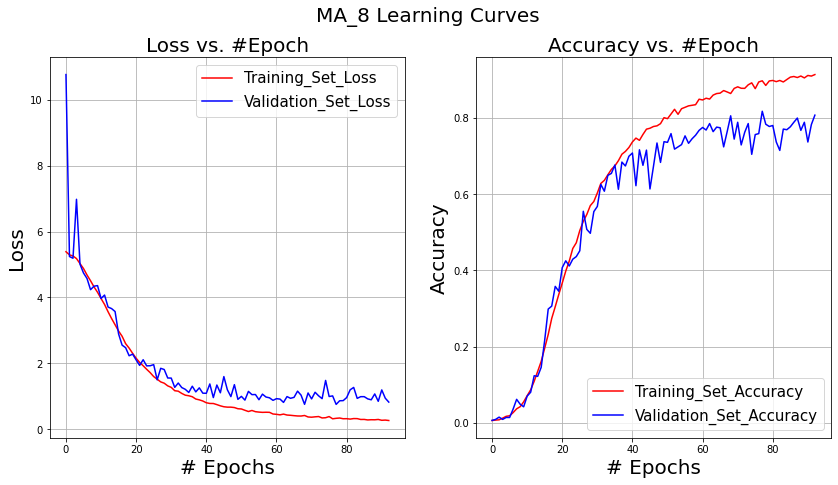

In [ ]:
hist_plot_dict = {0: [{'loss': ['r-', 'Training_Set_Loss'],
                       'val_loss': ['b-', 'Validation_Set_Loss']},
                      'Loss vs. #Epoch', 'Loss', '# Epochs'],
                  1: [{'categorical_accuracy': ['r-', 'Training_Set_Accuracy'],
                      'val_categorical_accuracy': ['b-', 'Validation_Set_Accuracy']},
                      'Accuracy vs. #Epoch', 'Accuracy', '# Epochs']
                  }
plot_lc(mod_file_pref, hi_path, hist_plot_dict, 2, 7, 7)

### Evaluate model on training and test sets

In [ ]:
# Evaluate model on training set
res = model.evaluate(x = train_generator, steps = len(train_generator), verbose = 1, return_dict = True)
print("Training set loss is %0.4f" % res['loss'])
print("Training set accuracy is %0.2f %%" % (100 * res['categorical_accuracy']))
print()
# Evaluate model on validation set
res = model.evaluate(x = val_generator, steps = len(val_generator), verbose = 1, return_dict = True)
print("Validation set loss is %0.4f" % res['loss'])
print("Validation set accuracy is %0.2f %%" % (100 * res['categorical_accuracy']))
print()
# Evaluate model on test set
res = model.evaluate(x = test_generator, steps = len(test_generator), verbose = 1, return_dict = True)
print("Test set loss is %0.4f" % res['loss'])
print("Test set accuracy is %0.2f %%" % (100 * res['categorical_accuracy']))

128/128 [==============================] - 177s 1s/step - loss: 0.2291 - categorical_accuracy: 0.9252
Training set loss is 0.2291
Training set accuracy is 92.52 %

19/19 [==============================] - 16s 831ms/step - loss: 0.7540 - categorical_accuracy: 0.8180
Validation set loss is 0.7540
Validation set accuracy is 81.80 %

108/108 [==============================] - 91s 846ms/step - loss: 0.7987 - categorical_accuracy: 0.8063
Test set loss is 0.7987
Test set accuracy is 80.63 %


### Plot Confusion matrix

In [ ]:
# Regenerate train, val and test generators without augmentation and shuffling
train_datagen_cm = ImageDataGenerator(preprocessing_function = preprocess_data)
val_datagen_cm = ImageDataGenerator(preprocessing_function = preprocess_data)
test_datagen_cm = ImageDataGenerator(preprocessing_function = preprocess_data)

train_gen_cm = train_datagen_cm.flow(X_train, y_train_ohe, batch_size = mod_bat_size,\
                                           shuffle = False)
val_gen_cm = val_datagen_cm.flow(X_val, y_val_ohe, batch_size = mod_bat_size,\
                                           shuffle = False)
test_gen_cm = test_datagen_cm.flow(X_test, y_test_ohe, batch_size = mod_bat_size,\
                                           shuffle = False)

plot_cm(train_gen_cm, val_gen_cm, test_gen_cm, y_train, y_val, y_test, 8, 8)

### Make Predictions

In [ ]:
### Use this to plot random images from a particular set
# samp_indices = np.random.randint(low = 0, high = X_train.shape[0], size = 10)
# fig_title = 'Random Images from training set'

### Use this to plot random images corresponding to a particular label
# label = 5
# full_indices = np.nonzero(y_train == label)[0]
# samp_indices = list(np.random.choice(full_indices, size = 10))
# fig_title = f'Images from training set with actual label = {label}'

### Use this to plot random images corresponding to incorrect predictions from a particular set
# y_train_pred = np.argmax(model.predict(x = train_gen_cm, steps = len(train_gen_cm), verbose = 0),\
#                          axis = 1)
# full_indices = np.nonzero(y_train != y_train_pred)[0]
# samp_indices = list(np.random.choice(full_indices, size = 10))
# fig_title = 'Images from training set corresponding to incorrect predictions'

### Use this to plot random images corresponding to incorrect predictions of a particular label
y_train_pred = np.argmax(model.predict(x = train_gen_cm, steps = len(train_gen_cm), verbose = 0),\
                         axis = 1)
label = 8
full_indices = np.nonzero(y_train == label)[0]
full_indices = full_indices[np.nonzero(y_train[full_indices] != y_train_pred[full_indices])]
samp_indices = list(np.random.choice(full_indices, size = 10))
fig_title = f'Images from training set with incorrect predictions of label = {label}'

# Predict and plot
predict_and_plot(X_train, y_train, samp_indices, model, 5, 5, 7, fig_title)